## start from the root directory of [neural_textures](https://github.com/Dolorousrtur/neural-textures) repo

In [1]:
import argparse
import os

import cv2
import numpy as np

from utils.common import get_rotation_matrix, to_sigm, itt, tti
from utils.demo import DemoInferer
import torch
import matplotlib.pyplot as plt

/local/home/agrigorev/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

checkpoint_path = 'data/checkpoint'
smplx_models_dir = '/local/home/agrigorev/Data/01_Projects/aux_data/smplx_capital/smplx/'
imsize = 512
person_id = "02"
renderer_path = os.path.join(checkpoint_path, 'renderer.pth')
ntex_path = os.path.join(checkpoint_path, 'ntex.pth')

texsegm_path = 'data/texsegm.npy'
inferer = DemoInferer(renderer_path, ntex_path, smplx_models_dir=smplx_models_dir, texsegm_path=texsegm_path, imsize=imsize,
                  pid_list=[person_id])


In [3]:
smplx_path = f'data/smplx_dicts/{person_id}.pkl'
vertices, K = inferer.load_smplx(smplx_path)
vertices, K, ltrb = inferer.crop_vertices(vertices, K)
K_inv = torch.inverse(K)

In [4]:

uv = inferer.uv_renderer(vertices, negbg=False)
ntexture = inferer.nstack.generate_batch([person_id])
ntexture = ntexture.sum(dim=1)
nrender = torch.nn.functional.grid_sample(ntexture, uv.permute(0, 2, 3, 1), align_corners=True)
renderer_input = dict(uv=uv, nrender=nrender)
with torch.no_grad():
    renderer_output = inferer.renderer(renderer_input)
    
fake_rgb = renderer_output['fake_rgb']
fake_segm = renderer_output['fake_segm']
fake_rgb = to_sigm(fake_rgb) * (fake_segm[:, :1] > 0.8)

ntexture_np = ntexture[0].detach().cpu().permute(1,2,0).numpy()
nrender_np = nrender[0].detach().cpu().permute(1,2,0).numpy()

ntexture_np -= ntexture_np.min()
ntexture_np /= ntexture_np.max()

nrender_np -= nrender_np.min()
nrender_np /= nrender_np.max()

fake_rgb_np = fake_rgb[0].detach().cpu().permute(1,2,0).numpy()

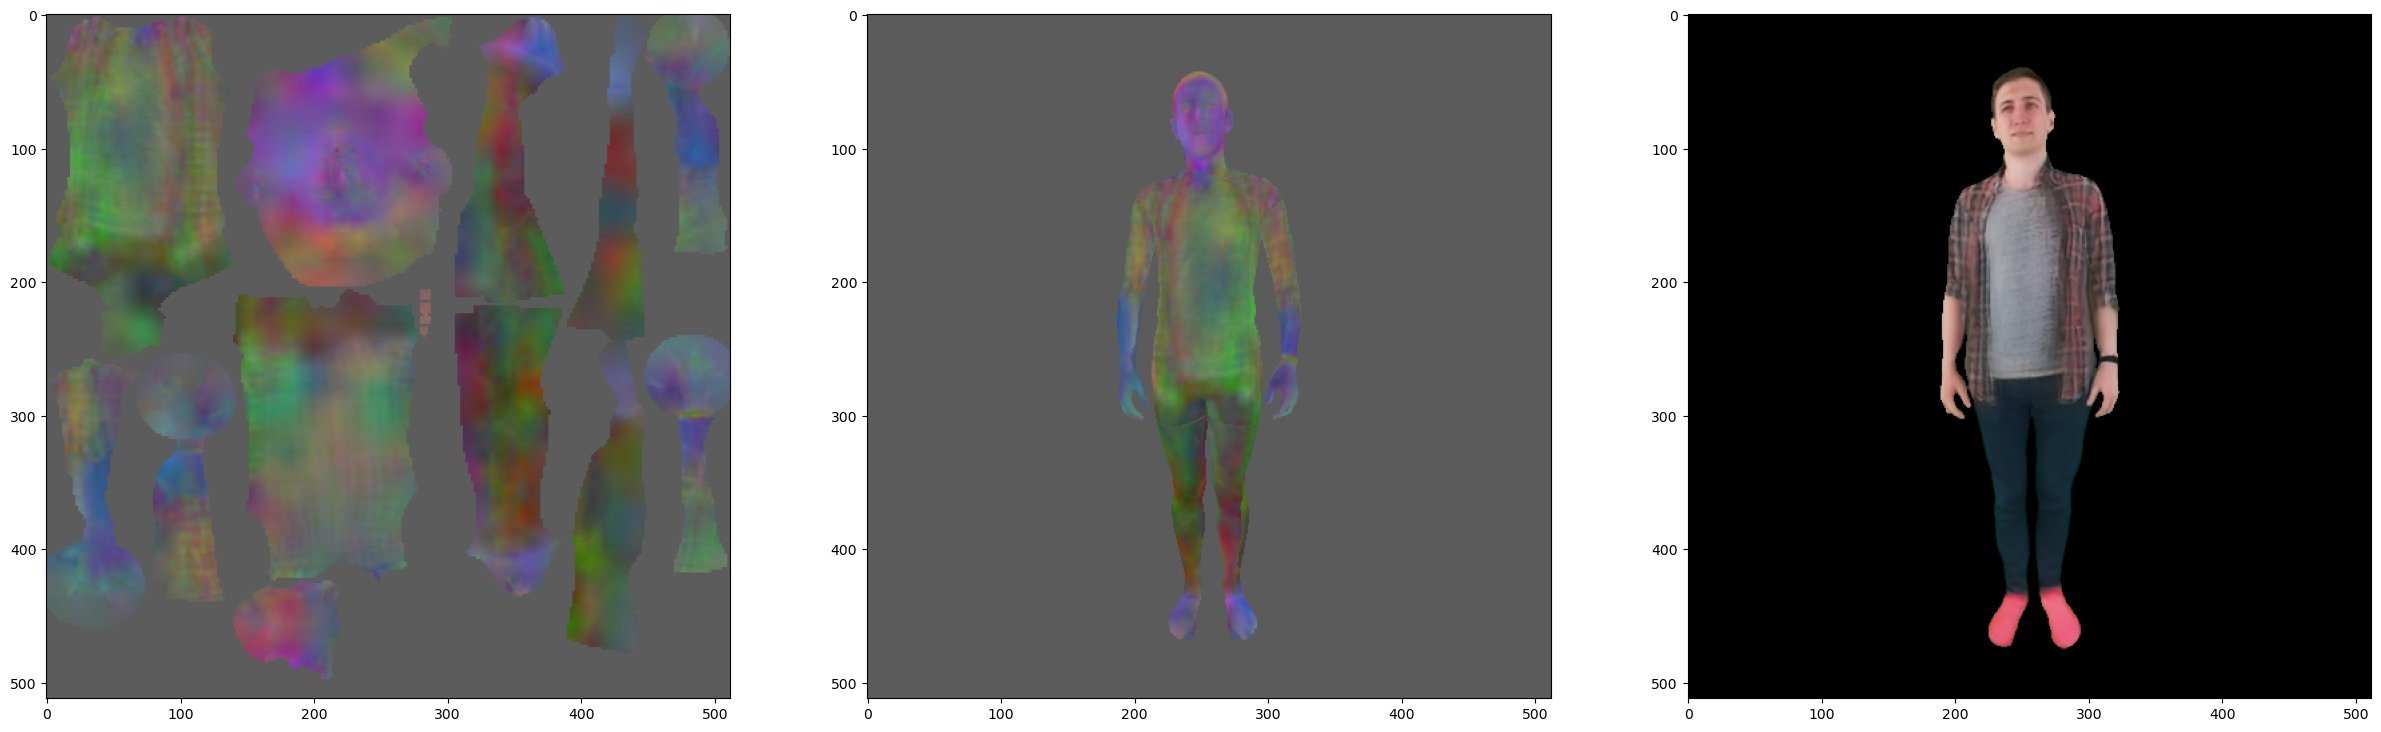

In [5]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(ntexture_np[..., :3])
ax[1].imshow(nrender_np[..., :3])
ax[2].imshow(fake_rgb_np)